[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khouakhi/ewin_mex/blob/master/%20Data_%20prep_%20level.ipynb)



> If you open this notebook using google Colab, run the following three cells allowing:
1) Google Drive mount
2) Clone the repository to your drive and get the repo associated data.










#### 1- Google drive mount: 



In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd './drive/My Drive'
%pwd

#### 2- Clone the repository to your drive 

In [0]:
!git clone https://github.com/khouakhi/ewin_mex.git

In this botebook we will explore the sensors data, tidying it and visualizing it. 
The original data is zipped subfolders by months for each sensor node, so we are going to unzip the subfolders, explore the data, clean it and save each time series by sesnor node.

#### Import the necessary modules and packages

In [0]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile   
from glob import glob
from datetime import datetime
from matplotlib.dates import DateFormatter, MonthLocator
# read level file example 
!pip install timestring
import timestring

#### Data source path 

In [0]:
data_source = './ewin_mex/data'
file_names = os.listdir(data_source)

#### Create an empty folder to unzip files
Here we are going to create an empty folder to unzip the subfolders.

In [0]:
# Create an empty folder (if it doesnt exist) for the unzipped files
unzipped_data = os.path.join(data_source,"unzipped_data")
try:
    os.mkdir(unzipped_data)
except OSError:
    print ("folder exists already %s:" % unzipped_data)
else:
    print ("Successfully created the directory %s " % unzipped_data)

#### Unzip all documents recursively 
The follwing function will iterate through each folder and subfolder to unzip the folders.

In [0]:
# function that goes through folders and unzip fils 
def unzip_files(data_source,output_file):
  for path, dir_list, file_list in os.walk(data_source):
      for file_name in file_list:
          if file_name.endswith(".zip"):
              abs_file_path = os.path.join(path, file_name)
              print(abs_file_path)
              zip_obj = ZipFile(abs_file_path, 'r')
              zip_obj.extractall(output_file)
              zip_obj.close()
  print("Successfully unzipped!")   

In [0]:
# apply the function 
unzip_files(data_source=data_source, output_file=unzipped_data)

./ewin_mex/data/Rivercore_aug.zip
./ewin_mex/data/Atmos_aug.zip
./ewin_mex/data/Rivercore_sep.zip
./ewin_mex/data/Atmos_jun.zip
./ewin_mex/data/Atmos_sep.zip
./ewin_mex/data/Atmos_jul.zip
./ewin_mex/data/Rivercore_jul.zip
./ewin_mex/data/Rivercore_jun.zip
Successfully unzipped!


### RiverCore data
Given the difference in the data format for the riverCore and Atmos data, we are going to explore them separately starting by the RiverCore files. 

We can loop through each subfolder and use the keyword "Node" to find all the paths of the thr RiverCore data. 

In [7]:
# find level files 
all_lvl_files = []
substring = "Node"#_10
for root, subdirs, files in os.walk(unzipped_data):
        for filename in files:
            if substring in filename:
                name_path = os.path.join(root,filename)
                all_lvl_files.append(name_path)
                
all_lvl_files

['./ewin_mex/data/unzipped_data/Rivercore_aug/August_Node10.txt',
 './ewin_mex/data/unzipped_data/Rivercore_aug/August_Node13.txt',
 './ewin_mex/data/unzipped_data/Rivercore_aug/August_Node14.txt',
 './ewin_mex/data/unzipped_data/Rivercore_aug/August_Node3.txt',
 './ewin_mex/data/unzipped_data/Rivercore_sep/September_Node13.txt',
 './ewin_mex/data/unzipped_data/Rivercore_sep/September_Node14.txt',
 './ewin_mex/data/unzipped_data/Rivercore_sep/September_Node3.txt',
 './ewin_mex/data/unzipped_data/Rivercore_sep/September_Node5.txt',
 './ewin_mex/data/unzipped_data/Rivercore_sep/September_Node6.txt',
 './ewin_mex/data/unzipped_data/Rivercore_jul/July_Node10.txt',
 './ewin_mex/data/unzipped_data/Rivercore_jul/July_Node13.txt',
 './ewin_mex/data/unzipped_data/Rivercore_jul/July_Node14.txt',
 './ewin_mex/data/unzipped_data/Rivercore_jul/July_Node3.txt',
 './ewin_mex/data/unzipped_data/Rivercore_jun/June_Node10.txt',
 './ewin_mex/data/unzipped_data/Rivercore_jun/June_Node13.txt',
 './ewin_mex

Now let's explore one file to see how it is structured before we build a function to apply for each RiverCore datasets.

In [0]:
# read level file example 
data = pd.read_csv(all_lvl_files[7],sep='\t',error_bad_lines=False, engine='python') #, header=None 
# Data summary
print(data.dtypes)
print(data.describe())
print(data.columns)
# rename variables 
new_columns = ['time_stamp','wl', 'sm']
data.columns = new_columns
# Check for NaNs
data.isna().any()
# remove last digits from time_stamp 
data['time_stamp'] = data['time_stamp'].str[:-5]+data['time_stamp'].str[-1:]
# correct the month name
if 'September'in all_lvl_files[7]:
  data['time_stamp'] = data['time_stamp'].str.replace('Septeber','september')
#apply timestring function 
data['time_stamp'] = data['time_stamp'].apply(timestring.Date) 
# convert date to string
data['time_stamp'] = data['time_stamp'].apply(str)
# parse datetime
data['time_stamp'] = pd.to_datetime(data['time_stamp'], format='%Y-%m-%d %H:%M:%S') 
#print(data.describe())
# convert stage to numeric
data['wl'] = data['wl'].apply(pd.to_numeric, errors='coerce')
data['sm'] = data['sm'].apply(pd.to_numeric, errors='coerce')
# set time_stamp as index
data = data.set_index('time_stamp')
# print dtypes 
print(data.dtypes)
# aggregate to hourly ts
hourly_lvl = data.resample('h').mean()

A quick plot

In [0]:
plt.plot(hourly_lvl['wl'])
plt.plot(hourly_lvl['sm'])

#### Define the function 

Use the information above to define a function to use for the rest of the files: 
Basically, read the RC files clean them, parse date time and export them by node.

In [0]:
def lvl_data_prep(file_name):
  data = pd.read_csv(file_name,sep='\t',error_bad_lines=False, engine='python') #, header=None 
  # rename variables 
  new_columns = ['time_stamp','wl', 'sm']
  data.columns = new_columns
  # remove the wrong rows
  data.isna().any()
  # remove last digits from time 
  data['time_stamp'] = data['time_stamp'].str[:-5]+data['time_stamp'].str[-1:]
  # correct September 
  if 'September'in file_name:
    data['time_stamp'] = data['time_stamp'].str.replace('Septeber','september')  
  # remove rows with "e"
  data = data[data.time_stamp!="e"]
  # apply the timestring function 
  data['time_stamp'] = data['time_stamp'].apply(timestring.Date) 
  # convert date to string
  data['time_stamp'] = data['time_stamp'].apply(str)
  # parse dates 
  data['time_stamp'] = pd.to_datetime(data['time_stamp'], format='%Y-%m-%d %H:%M:%S') 
  # convert stage to numeric
  data['wl'] = data['wl'].apply(pd.to_numeric, errors='coerce')
  data['sm'] = data['sm'].apply(pd.to_numeric, errors='coerce')
  # set time_stamp as index
  data = data.set_index('time_stamp')
  # aggerate to hourly data
  hourly_data = data.resample('h').mean()
  return(hourly_data)

Create a folder to put our RC tidy data

In [10]:
# create new folder for the processed precip data
hourly_level = os.path.join(data_source,"hourly_level")
try:
    os.mkdir(hourly_level)
except OSError:
    print ("file exists already %s:" % hourly_level)
else:
    print ("Successfully created the directory %s " % hourly_level)

Successfully created the directory ./ewin_mex/data/hourly_level 


Apply the function and aggregate to hourly and save files by station

In [11]:
# iterate through all rainfall files  
for lvl_file in all_lvl_files:
  print(lvl_file)
  hourly_lvl = lvl_data_prep(lvl_file)
  # new file name
  rc_stations = ['Node'+str(i) for i in range(1,15)]
  for nd in rc_stations:
    if nd in lvl_file:
      fname = nd
  # define path 
  new_name_path = os.path.join(hourly_level,f'rc_{fname}.csv')
  # if the file exists append, if not create new
  if os.path.isfile(new_name_path):
    hourly_lvl.to_csv(new_name_path,   mode='a', header=False)
  else:
    hourly_lvl.to_csv(os.path.join(hourly_level,f'rc_{fname}.csv'))

./ewin_mex/data/unzipped_data/Rivercore_aug/August_Node10.txt
./ewin_mex/data/unzipped_data/Rivercore_aug/August_Node13.txt


Skipping line 30660: Expected 3 fields in line 30660, saw 4
Skipping line 35342: Expected 3 fields in line 35342, saw 4


./ewin_mex/data/unzipped_data/Rivercore_aug/August_Node14.txt
./ewin_mex/data/unzipped_data/Rivercore_aug/August_Node3.txt


Skipping line 16568: Expected 3 fields in line 16568, saw 4


./ewin_mex/data/unzipped_data/Rivercore_sep/September_Node13.txt


Skipping line 12654: Expected 3 fields in line 12654, saw 4
Skipping line 21604: Expected 3 fields in line 21604, saw 4
Skipping line 35073: Expected 3 fields in line 35073, saw 4
Skipping line 77855: Expected 3 fields in line 77855, saw 4


./ewin_mex/data/unzipped_data/Rivercore_sep/September_Node14.txt


Skipping line 7001: Expected 3 fields in line 7001, saw 4
Skipping line 13874: Expected 3 fields in line 13874, saw 4


./ewin_mex/data/unzipped_data/Rivercore_sep/September_Node3.txt


Skipping line 3478: Expected 3 fields in line 3478, saw 4


./ewin_mex/data/unzipped_data/Rivercore_sep/September_Node5.txt


Skipping line 4466: Expected 3 fields in line 4466, saw 4


./ewin_mex/data/unzipped_data/Rivercore_sep/September_Node6.txt
./ewin_mex/data/unzipped_data/Rivercore_jul/July_Node10.txt


Skipping line 32167: Expected 3 fields in line 32167, saw 4


./ewin_mex/data/unzipped_data/Rivercore_jul/July_Node13.txt


Skipping line 22435: Expected 3 fields in line 22435, saw 4


./ewin_mex/data/unzipped_data/Rivercore_jul/July_Node14.txt
./ewin_mex/data/unzipped_data/Rivercore_jul/July_Node3.txt
./ewin_mex/data/unzipped_data/Rivercore_jun/June_Node10.txt
./ewin_mex/data/unzipped_data/Rivercore_jun/June_Node13.txt
./ewin_mex/data/unzipped_data/Rivercore_jun/June_Node14.txt
./ewin_mex/data/unzipped_data/Rivercore_jun/June_Node3.txt


Skipping line 8595: Expected 3 fields in line 8595, saw 4


#### Plot RC data by sensor

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


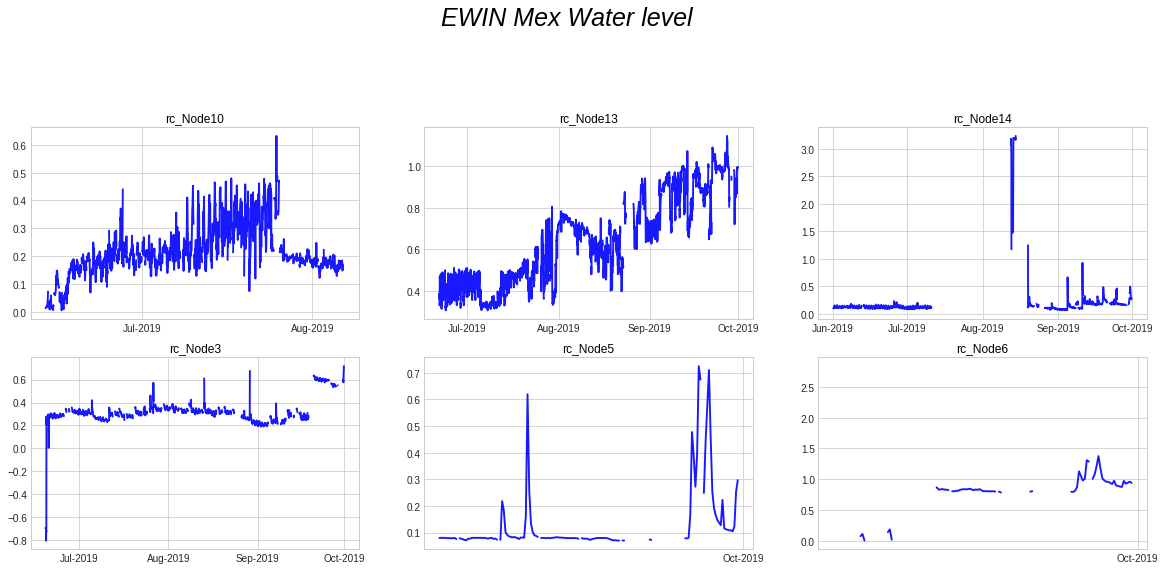

In [12]:
# list files
lvl_file_names = os.listdir(hourly_level)
# Initialize the figure
plt.style.use('seaborn-whitegrid')
# create a color palette
palette = plt.get_cmap('Set3')

fig = plt.figure(figsize=(20, 12))
num = 0
for i in lvl_file_names:
  this_file = os.path.join(hourly_level,i)
  df = pd.read_csv(this_file,infer_datetime_format= True,
                   parse_dates=True,index_col='time_stamp') 
  # sort by datetime
  df = df.sort_values(by=['time_stamp'])
  df = df.resample('h').mean()
  num+=1
  ax = fig.add_subplot(3,3, num)
  ax.plot(df['wl'], marker='', color='blue', linewidth=1.9, alpha=0.9, label=i)
 # Add title
  plt.title(i[:-4], loc='center', fontsize=12, fontweight=0, color="black")
# general title
  plt.suptitle("EWIN Mex Water level ", fontsize=25, fontweight=0,
               color='black', style='italic', y=1.02)

  months = MonthLocator()
  monthsFmt = DateFormatter("%b-%Y")
  ax.xaxis.set_major_locator(months)
  ax.xaxis.set_major_formatter(monthsFmt)

### Atmos data

In [0]:
unzip_data_folder = os.path.join(data_source,"unzipped_data")

### Find all ATMOS file paths 

In [0]:
# find level files 
all_prcp_files = []
substring = "_10"
for root, subdirs, files in os.walk(unzip_data_folder):
        for filename in files:
            if substring in filename:
                name_path = os.path.join(root,filename)
                all_prcp_files.append(name_path)
                
all_prcp_files

In [0]:
# create new folder for the processed precip data
hourly_atmos = os.path.join(data_source,"hourly_atmos")
try:
    os.mkdir(hourly_atmos)
except OSError:
    print ("file exists already %s:" % hourly_atmos)
else:
    print ("Successfully created the directory %s " % hourly_atmos)

In [0]:
for p in all_prcp_files:
  print(p)
  # date parser 
  dparser = lambda x:datetime.strptime(x, "%d/%m/%Y %H:%M")
  # read txt file   
  if 'sep' in p:
    data = pd.read_csv(p,sep='\t',
                parse_dates=['Date'],
                index_col='Date',
                date_parser = dparser,
                error_bad_lines=False,
                encoding='utf-16')
  else:
    data = pd.read_csv(p,sep='\t',
                parse_dates=['Date'],
                index_col='Date',
                date_parser = dparser,
                error_bad_lines=False)  
  # rename variables 
  new_columns = ['air_temp','relative_hum', 'prcp','solar_rad','vapor_press']
  data.columns = new_columns
  # set time_stamp as index
  data.index.names = ['time_stamp']
  # remove the wrong rows
  data.isna().any()
  data.dtypes
  print('missing data per column:\n',data.isnull().sum())
  # find missing data
  missing_data = data[data['air_temp'].isnull()]
  # quick plot 
  data['prcp'].plot()

  set1_noPrcp = data.drop('prcp',1).resample('h').mean()
  set2_Prcp = data.prcp.resample('h').sum(min_count=1)
  # to hourly 
  atmos_hourly = pd.concat([set1_noPrcp, set2_Prcp], axis=1)
  # new file name
  atmos_stations = ['Atmos'+str(i) for i in range(1,9)]
  for s in atmos_stations:
    if s in p:
      fname = s
  # define path 
  new_name_path = os.path.join(hourly_atmos,f'{fname}.csv')
  # if the file exists append, if not create new
  if os.path.isfile(new_name_path):
    atmos_hourly.to_csv(new_name_path,mode='a', header=False)
  else:
    atmos_hourly.to_csv(os.path.join(hourly_atmos,f'{fname}.csv'))



In [0]:
# list files
prcp_file_names = os.listdir(hourly_atmos)
# Initialize the figure
plt.style.use('seaborn-whitegrid')
# variable to plot across stations
var = "prcp"
# fugure config 
fig = plt.figure(figsize=(20, 12))
num = 0
for i in prcp_file_names:
  this_file = os.path.join(hourly_atmos,i)
  df = pd.read_csv(this_file,infer_datetime_format= True,
                   parse_dates=True,index_col='time_stamp') 
  # sort by datetime
  df = df.sort_values(by=['time_stamp'])
  df = df.resample('h').mean()
  num+=1
  ax = fig.add_subplot(3,3, num)
  ax.plot(df[var], marker='', color='blue', linewidth=1.9, alpha=0.9, label=i)
 # Add title
  plt.title(i[:-4]+var, loc='center', fontsize=12, fontweight=0, color="black")
# general title
  plt.suptitle("EWIN Mex Atmos ", fontsize=25, fontweight=0,
               color='black', style='italic', y=1.02)

  months = MonthLocator()
  monthsFmt = DateFormatter("%b-%Y")
  ax.xaxis.set_major_locator(months)
  ax.xaxis.set_major_formatter(monthsFmt)